In [32]:
import pandas as pd
import copy
import numpy as np
import math
from sklearn import metrics  # mean_squared_error, mean_absolute_error, median_absolute_error, explained_variance_score, r2_score
import matplotlib.pyplot as plt  
import statsmodels.api as sm  
from statsmodels.formula.api import ols  
import seaborn as sns  
import pandas.tseries  
plt.style.use('fivethirtyeight') 

In [33]:
#Downloading the database reserved for training
train_data=pd.read_csv('raw train data.txt', sep = ' ', header=None)

#Downloading the database reserved for testing
test_data=pd.read_csv('raw test data.txt', sep = ' ', header=None)

data=['id','cycle','setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21','26','27']

train_data.columns = data
test_data.columns = data

data=['id','cycle','setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']
train_data = train_data[data]
test_data = test_data[data]
print('shape of training data =', train_data.shape, ',', 'shape of testing data =', test_data.shape)

shape of training data = (20631, 26) , shape of testing data = (13096, 26)


In [3]:
train_data.head()

id  cycle  setting1  setting2  setting3      s1      s2       s3       s4  \
0   1      1   -0.0007   -0.0004     100.0  518.67  641.82  1589.70  1400.60   
1   1      2    0.0019   -0.0003     100.0  518.67  642.15  1591.82  1403.14   
2   1      3   -0.0043    0.0003     100.0  518.67  642.35  1587.99  1404.20   
3   1      4    0.0007    0.0000     100.0  518.67  642.35  1582.79  1401.87   
4   1      5   -0.0019   -0.0002     100.0  518.67  642.37  1582.85  1406.22   

      s5  ...     s12      s13      s14     s15   s16  s17   s18    s19  \
0  14.62  ...  521.66  2388.02  8138.62  8.4195  0.03  392  2388  100.0   
1  14.62  ...  522.28  2388.07  8131.49  8.4318  0.03  392  2388  100.0   
2  14.62  ...  522.42  2388.03  8133.23  8.4178  0.03  390  2388  100.0   
3  14.62  ...  522.86  2388.08  8133.83  8.3682  0.03  392  2388  100.0   
4  14.62  ...  522.19  2388.04  8133.80  8.4294  0.03  393  2388  100.0   

     s20      s21  
0  39.06  23.4190  
1  39.00  23.4236  
2  38.95  23.3442  
3  38.88  23.3739  
4  38.90  23.4044  

[5 rows x 26 columns]

In [4]:
test_data.head()

id  cycle  setting1  setting2  setting3      s1      s2       s3       s4  \
0   1      1    0.0023    0.0003     100.0  518.67  643.02  1585.29  1398.21   
1   1      2   -0.0027   -0.0003     100.0  518.67  641.71  1588.45  1395.42   
2   1      3    0.0003    0.0001     100.0  518.67  642.46  1586.94  1401.34   
3   1      4    0.0042    0.0000     100.0  518.67  642.44  1584.12  1406.42   
4   1      5    0.0014    0.0000     100.0  518.67  642.51  1587.19  1401.92   

      s5  ...     s12      s13      s14     s15   s16  s17   s18    s19  \
0  14.62  ...  521.72  2388.03  8125.55  8.4052  0.03  392  2388  100.0   
1  14.62  ...  522.16  2388.06  8139.62  8.3803  0.03  393  2388  100.0   
2  14.62  ...  521.97  2388.03  8130.10  8.4441  0.03  393  2388  100.0   
3  14.62  ...  521.38  2388.05  8132.90  8.3917  0.03  391  2388  100.0   
4  14.62  ...  522.15  2388.03  8129.54  8.4031  0.03  390  2388  100.0   

     s20      s21  
0  38.86  23.3735  
1  39.02  23.3916  
2  39.08  23.4166  
3  39.00  23.3737  
4  38.99  23.4130  

[5 rows x 26 columns]

In [ ]:
train_data.isnull().sum()

In [ ]:
test_data.isnull().sum()

In [34]:
    #creation du label 'ttf' pour train_data
    max_cycles = []
    ids = []
    for m_id in pd.unique(train_data.id):
        max_cycle = train_data[train_data['id'] == m_id]['cycle'].max() #subset of X_data (it designates cycles for each engine individually, and then it takes the maximum value.)
        max_cycles.append(max_cycle)
        ids.append(m_id)

    df_max_cycle = ({'id': ids, 'last_cycle': max_cycles})
    df_max_cycle = pd.DataFrame.from_dict(df_max_cycle)

    train_data = pd.merge(train_data, df_max_cycle, on='id') #add a column 'last_cycle' (data frame ['id','last_cycle']) à X_data: when 'id' matches, it associates its max_cycle (uwill find repetetive lines)
    train_data['ttf'] = train_data['last_cycle'] - train_data['cycle'] #objective:calculate how many cycles remain before failure, from now on i have two extra columns (ttf and max_cycle)
    train_data.drop(['last_cycle'], axis=1, inplace=True) #'last_cycle' was intermediate to creat 'ttf'
    
    
    #creation of label 'ttf' for test_data
    max_cycles = []
    ids = []
    for m_id in pd.unique(test_data.id):
        max_cycle = test_data[test_data['id'] == m_id]['cycle'].max() 
        max_cycles.append(max_cycle)
        ids.append(m_id)

    df_max_cycle = ({'id': ids, 'last_cycle': max_cycles})
    df_max_cycle = pd.DataFrame.from_dict(df_max_cycle)

    test_data = pd.merge(test_data, df_max_cycle, on='id')
    test_data['ttf'] = test_data['last_cycle'] - test_data['cycle'] 
    test_data.drop(['last_cycle'], axis=1, inplace=True)     
  



In [ ]:
train_data.head()

In [ ]:
test_data.head()

In [35]:
#traindata features preparation
X_train = train_data[['setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']]

#testdata features preparation
X_test = test_data[['setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']]

#train data label
y_train=train_data['ttf']
y_test=test_data['ttf']


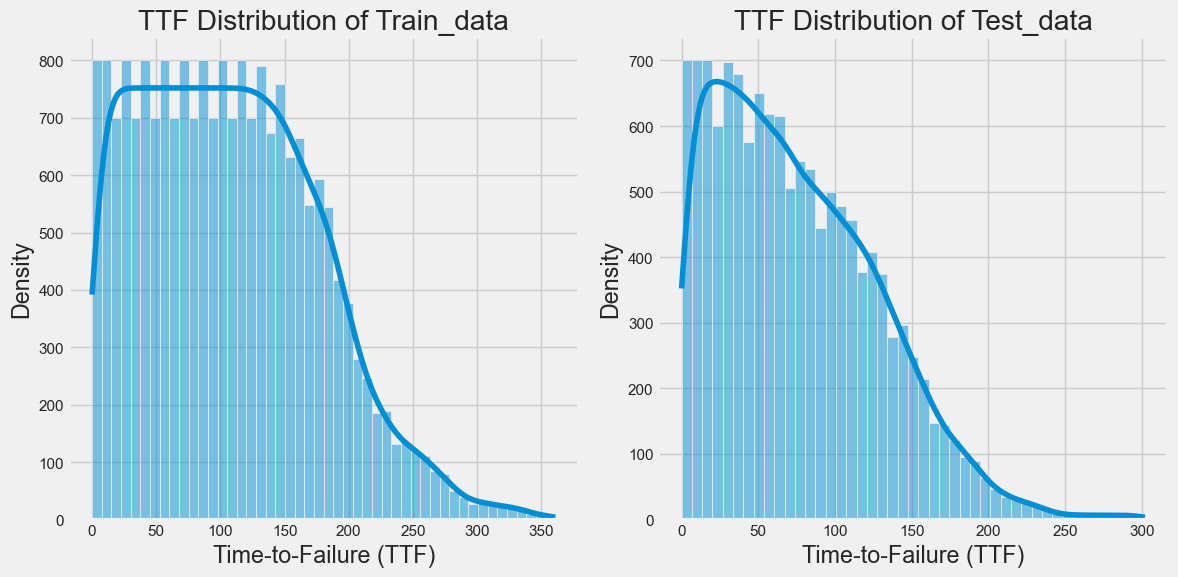

In [25]:
# Create subplots for both train_data['ttf'] and test_data['ttf']
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(train_data['ttf'], kde=True)
plt.xlabel('Time-to-Failure (TTF)')
plt.ylabel('Density')
plt.title('TTF Distribution of Train_data')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.histplot(test_data['ttf'], kde=True)
plt.xlabel('Time-to-Failure (TTF)')
plt.ylabel('Density')
plt.title('TTF Distribution of Test_data')
plt.grid(True)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

train and test labels are skewed to the left--> apply function to normalize it

In [36]:
# Check if any value in the 'ttf' column is negative or null

negative_value = (train_data['ttf'] <= 0).any()

if negative_value:
    print("Train data's ttf has nul or negative values.")
else:
    print("Train data's ttf has no negative value.")
    
negative_value = (test_data['ttf'] < 0).any()
if negative_value:
    print('test data label contains nul or negative values')
else:
    print('test data label is positive')

Train data's ttf has nul or negative values.
test data label is positive


TTF (Time-to-Failure) contains null values, so we cannot apply the logarithm function, instead we will apply square root

In [47]:
# Apply the square root transformation to test_ttf
test_data['ttf_fixed'] = np.sqrt(test_data['ttf'])
#name the new label datafram
y_test_fixed = test_data['ttf_fixed']

# visualise the transformed dataframe
print(y_test_fixed.head())

# Apply the square root transformation to train_ttf
train_data['train_fixed'] = np.sqrt(train_data['ttf'])
#name the new label datafram
y_train_fixed = train_data['ttf_fixed']

# visualise the transformed dataframe
print(y_train_fixed.head())



0    5.477226
1    5.385165
2    5.291503
3    5.196152
4    5.099020
Name: ttf_fixed, dtype: float64
0    13.820275
1    13.784049
2    13.747727
3    13.711309
4    13.674794
Name: ttf_fixed, dtype: float64


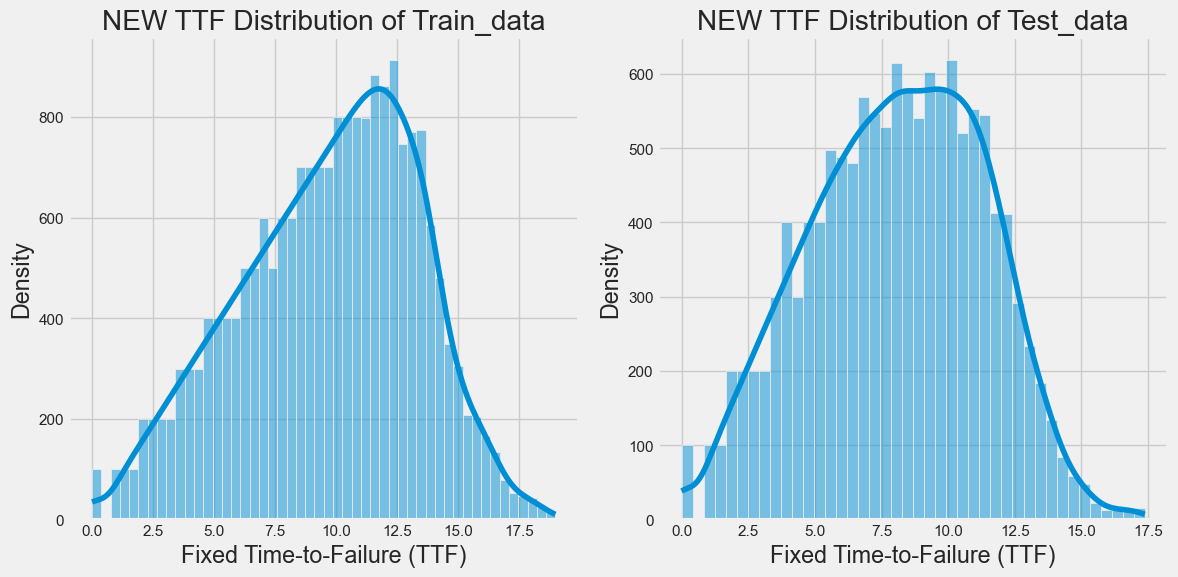

In [48]:
# Create subplots for both train_data['ttf_fixed'] and test_data['ttf_fixed']
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(train_data['ttf_fixed'], kde=True)
plt.xlabel('Fixed Time-to-Failure (TTF)')
plt.ylabel('Density')
plt.title('NEW TTF Distribution of Train_data')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.histplot(test_data['ttf_fixed'], kde=True)
plt.xlabel('Fixed Time-to-Failure (TTF)')
plt.ylabel('Density')
plt.title('NEW TTF Distribution of Test_data')
plt.grid(True)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

label no longer skewed to the left

In [49]:
#Check if there are any NaN (Not a Number) values
print(np.any(np.isnan(y_train_fixed)))
print(np.any(np.isinf(y_train_fixed)))


False
False


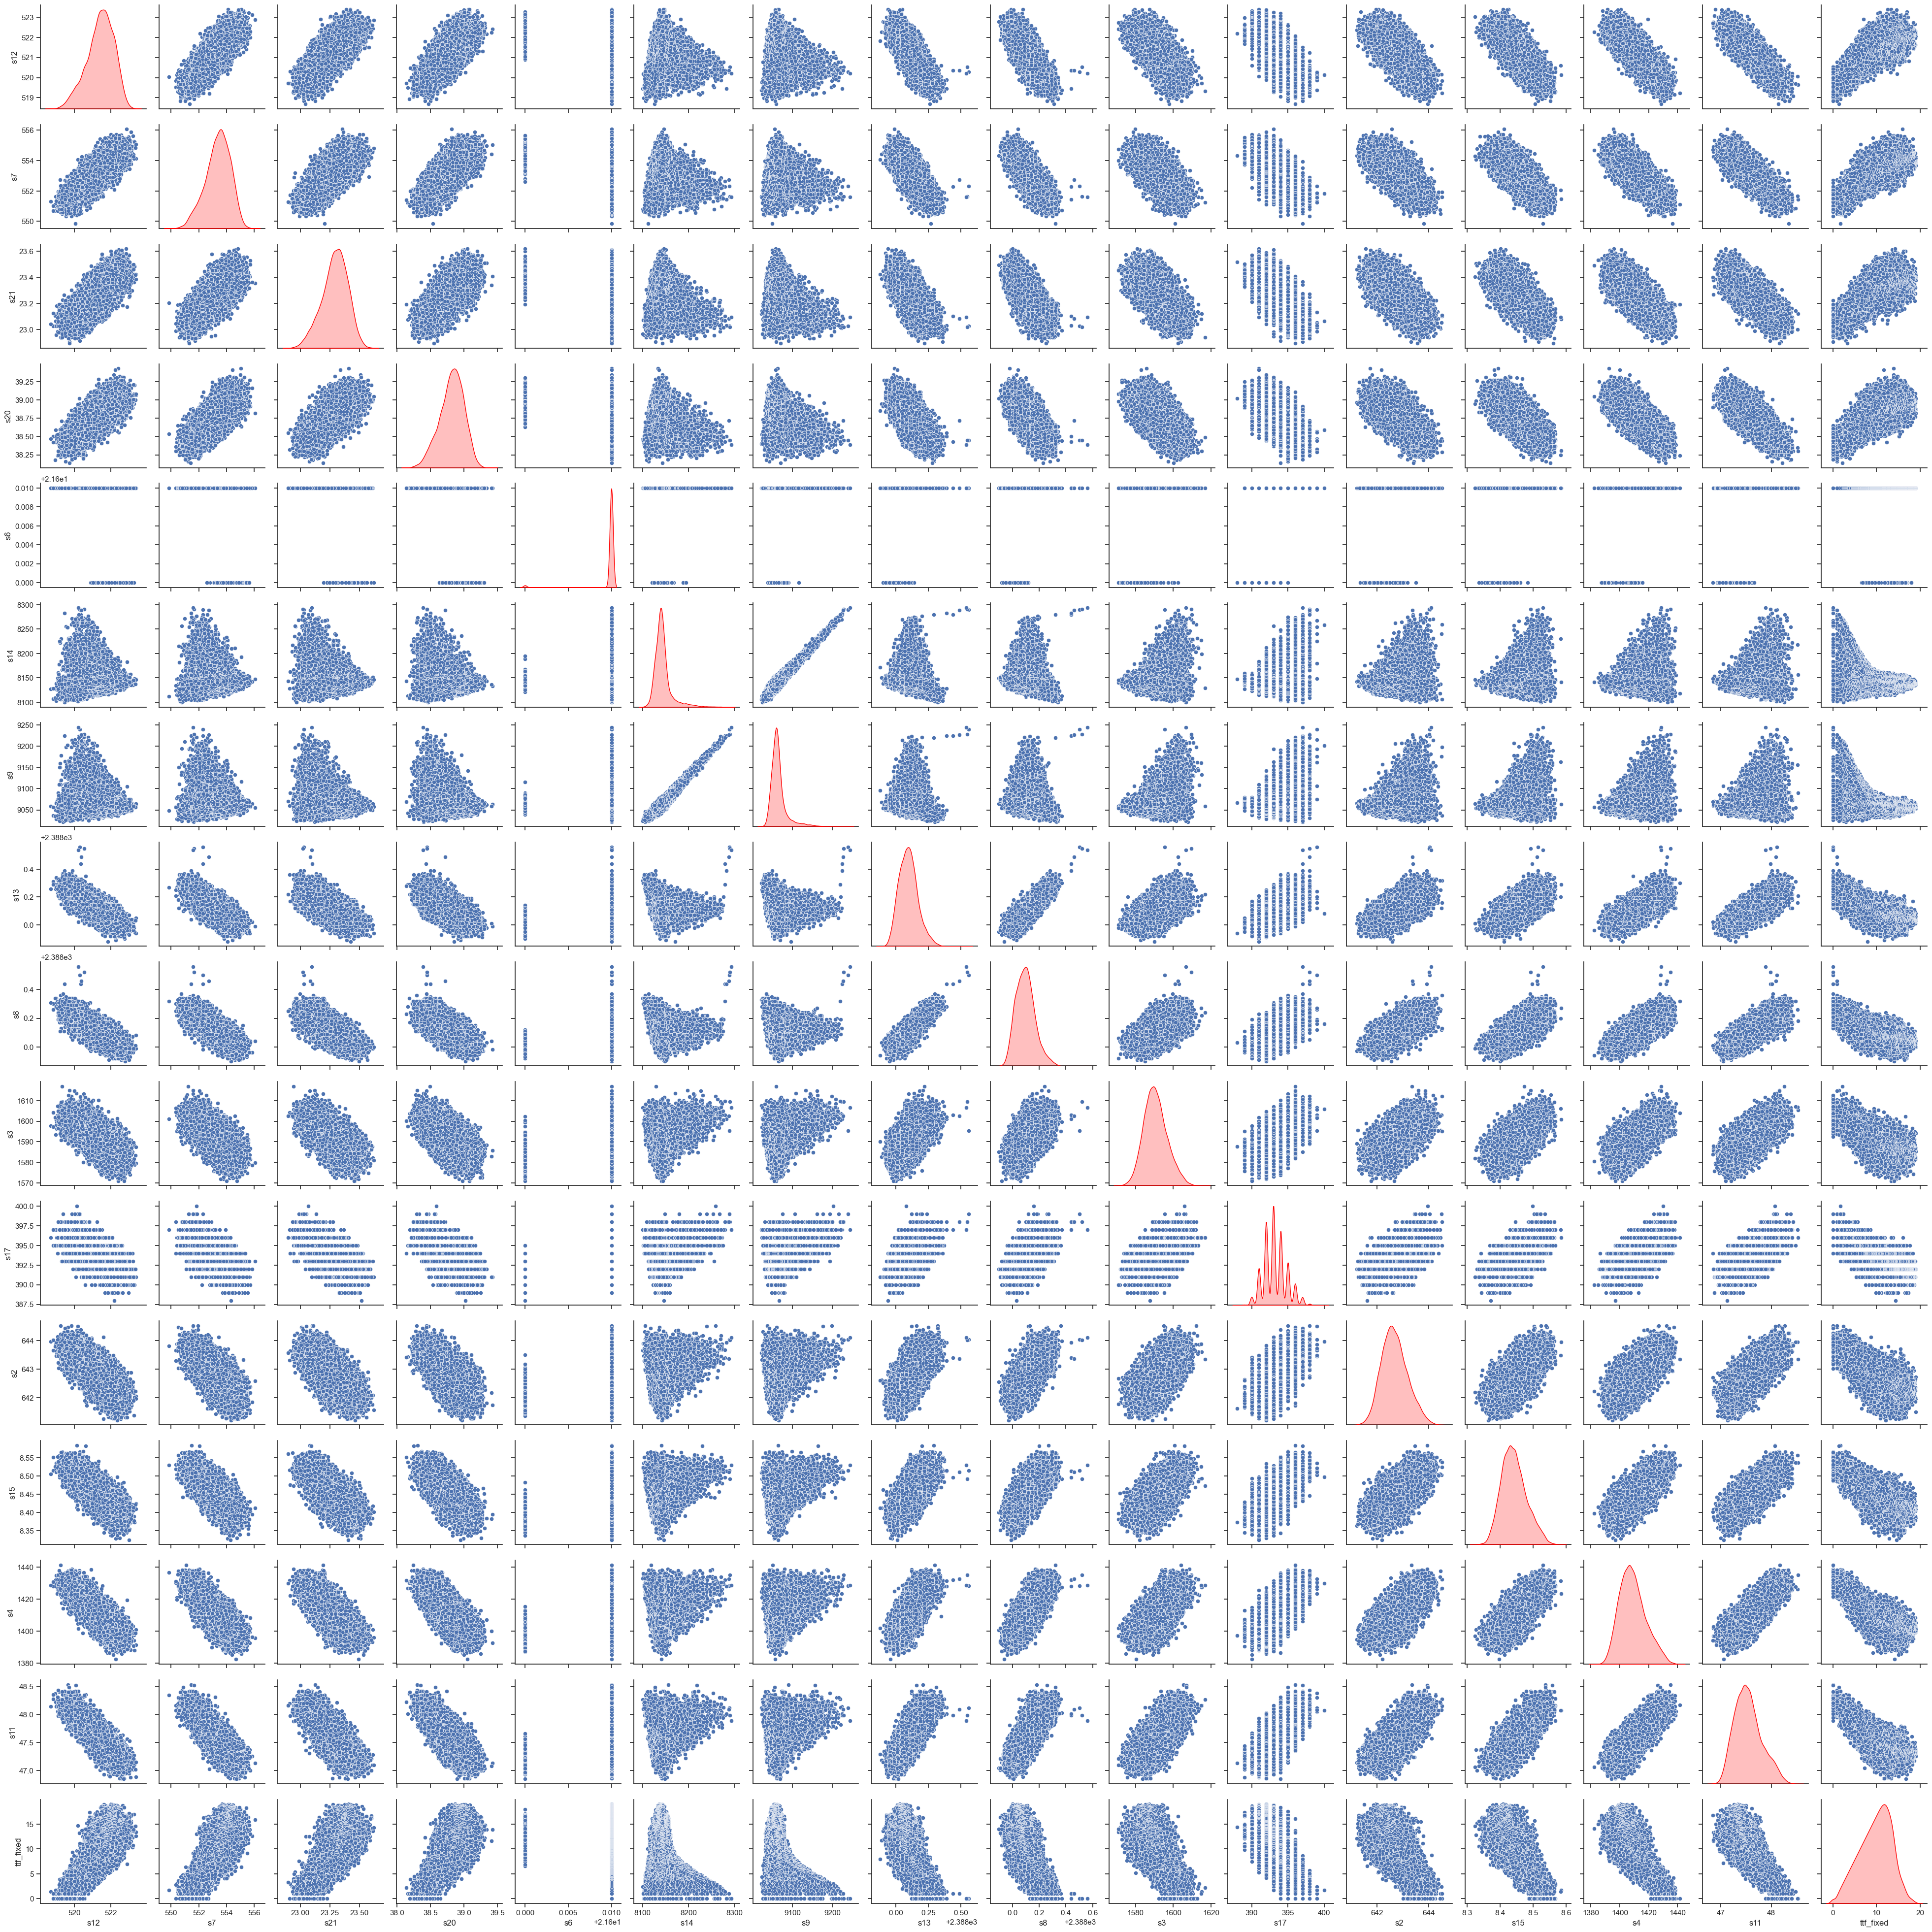

In [19]:
# Visualisation de la distribution des features and du label
feat_corr_ttf = ['s12', 's7', 's21', 's20', 's6', 's14', 's9', 's13', 's8', 's3', 's17', 's2', 's15', 's4', 's11']
Visualisation_data = X_train[feat_corr_ttf].copy() #copy()pour ne pas modifier X_train originale
Visualisation_data['ttf_fixed'] = y_train_fixed
sns.set(style="ticks")

g = sns.pairplot(Visualisation_data, diag_kind='kde', diag_kws={'color': 'red'}) # kernel density estimate


In [50]:
Visualisation_data.head()

s12      s7      s21    s20     s6      s14       s9      s13       s8  \
0  521.66  554.36  23.4190  39.06  21.61  8138.62  9046.19  2388.02  2388.06   
1  522.28  553.75  23.4236  39.00  21.61  8131.49  9044.07  2388.07  2388.04   
2  522.42  554.26  23.3442  38.95  21.61  8133.23  9052.94  2388.03  2388.08   
3  522.86  554.45  23.3739  38.88  21.61  8133.83  9049.48  2388.08  2388.11   
4  522.19  554.00  23.4044  38.90  21.61  8133.80  9055.15  2388.04  2388.06   

        s3  s17      s2     s15       s4    s11  ttf_fixed  
0  1589.70  392  641.82  8.4195  1400.60  47.47  13.820275  
1  1591.82  392  642.15  8.4318  1403.14  47.49  13.784049  
2  1587.99  390  642.35  8.4178  1404.20  47.27  13.747727  
3  1582.79  392  642.35  8.3682  1401.87  47.13  13.711309  
4  1582.85  393  642.37  8.4294  1406.22  47.28  13.674794

In [51]:
def regression_eval_metrics(actual, predicted):
    
    """Calculate regression evaluation metrics.
    
    Args:
        model (str): The model name identifier
        actual (series): Contains the test label values
        predicted (series): Contains the predicted values
        
    Returns:
        dataframe: The combined metrics in single dataframe
    
    
    """
    regr_metrics = {
                        'Root Mean Squared Error' : metrics.mean_squared_error(actual, predicted)**0.5,
                        'Mean Absolute Error' : metrics.mean_absolute_error(actual, predicted),
                        'Explained Variance' : metrics.explained_variance_score(actual, predicted)
                   }

    #return reg_metrics
    df_regr_metrics = pd.DataFrame.from_dict(regr_metrics, orient='index')
    return df_regr_metrics


In [58]:
def compute_cost(X, y, w, b): 
    """
    compute cost
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      cost (scalar): cost
    """
    m = X.shape[0]
    cost = 0.0
    for i in range(m):                                
        f_wb_i = np.dot(X[i], w) + b           #(n,)(n,) = scalar (see np.dot)
        cost = cost + (f_wb_i - y[i])**2       #scalar
    cost = cost / (2 * m)                      #scalar    
    return cost

In [59]:
def compute_gradient(X, y, w, b): 
    """
    Computes the gradient for linear regression 
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w. 
      dj_db (scalar):       The gradient of the cost w.r.t. the parameter b. 
    """
    m,n = X.shape           #(number of examples, number of features)
    dj_dw = np.zeros((n,))
    dj_db = 0.

    for i in range(m):                             
        err = (np.dot(X[i], w) + b) - y[i]   
        for j in range(n):                         
            dj_dw[j] = dj_dw[j] + err * X[i, j]    
        dj_db = dj_db + err                        
    dj_dw = dj_dw / m                                
    dj_db = dj_db / m                                
        
    return dj_db, dj_dw

In [60]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters):
    """
    Performs batch gradient descent to learn w and b. Updates w and b by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X (ndarray (m,n))   : Data, m examples with n features
      y (ndarray (m,))    : target values
      w_in (ndarray (n,)) : initial model parameters  
      b_in (scalar)       : initial model parameter
      cost_function       : function to compute cost
      gradient_function   : function to compute the gradient
      alpha (float)       : Learning rate
      num_iters (int)     : number of iterations to run gradient descent
      
    Returns:
      w (ndarray (n,)) : Updated values of parameters 
      b (scalar)       : Updated value of parameter 
      """
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db,dj_dw = gradient_function(X, y, w, b)   ##None

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               ##None
        b = b - alpha * dj_db               ##None
      
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            J_history.append( cost_function(X, y, w, b))

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]:8.2f}   ")
        
    return w, b, J_history #return final w,b and J history for graphing

In [65]:
#prepare parameters:

# convert dataframes to numpy arrays
X_train_reg = np.array(X_train)
y_train_fixed_reg = np.array(y_train_fixed)

initial_w = np.zeros(X_train.shape[1])
initial_b = 0

# some gradient descent settings
iterations = 100
alpha = 0.00000001123

# run gradient descent 
w_final, b_final, J_hist = gradient_descent(X_train_reg, y_train_fixed, initial_w, initial_b,
                                            compute_cost, compute_gradient, alpha, iterations)
                                            
print(f"b,w found by gradient descent: {b_final:0.2f},{w_final} ")

Iteration    0: Cost    47.24   
Iteration   10: Cost    15.58   
Iteration   20: Cost     8.67   
Iteration   30: Cost     7.17   
Iteration   40: Cost     6.84   
Iteration   50: Cost     6.77   
Iteration   60: Cost     6.76   
Iteration   70: Cost     6.75   
Iteration   80: Cost     6.75   
Iteration   90: Cost     6.75   
b,w found by gradient descent: 0.00,[-3.67709582e-11 -3.81385771e-12  6.04802262e-06  3.13692789e-05
  3.74845953e-05  7.98020569e-05  5.73394202e-05  8.84220907e-07
  1.30626916e-06  3.61178697e-05  1.44250294e-04  5.07120339e-04
  7.86242941e-08  2.02790409e-06  3.37926317e-05  1.44248254e-04
  4.64211432e-04  4.00396829e-07  1.81440679e-09  1.94881393e-05
  1.44426780e-04  6.04802262e-06  2.86713626e-06  1.72207142e-06] 


In [66]:
#evaluating model
weight = w_final
bias= b_final

# convert dataframes to numpy arrays
X_test_reg = np.array(X_test)
y_test_fixed_reg = np.array(y_test_fixed)

y_pred=[]
for i in range(X_test_reg.shape[0]):
    # calculate predicted values of ttf
    y_predict = np.dot(X_test_reg[i], weight) + bias
    y_pred.append(y_predict)
    
max(y_pred - y_test_fixed_reg)

9.78654713773738

In [69]:
regression_eval_metrics(y_test_fixed_reg, y_pred)


0
Root Mean Squared Error  3.667032
Mean Absolute Error      2.939912
Explained Variance      -0.000935

The model can predict the Time To Failure with an error of RMS = 3.6671032,
                                                           MAE = 2.939912,
                                                           EV  = -0.000935
